# Importing Required Modules

In [21]:
#First import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import rasterio
from scipy import stats
from sklearn.cluster import *

# Accessing All the image files using glob

In [22]:
#First I obtain all the images available in the data folder
ImgList = glob.glob("./IMG_DATA/*.jp2")
#Now I check for the files present in my image list
for i in ImgList:
    print(i)

./IMG_DATA/T27WXN_20190820T125301_B01_60.jp2
./IMG_DATA/T27WXN_20190820T125301_B02_60.jp2
./IMG_DATA/T27WXN_20190820T125301_B03_60.jp2
./IMG_DATA/T27WXN_20190820T125301_B04_60.jp2
./IMG_DATA/T27WXN_20190820T125301_B05_60.jp2
./IMG_DATA/T27WXN_20190820T125301_B06_60.jp2
./IMG_DATA/T27WXN_20190820T125301_B07_60.jp2
./IMG_DATA/T27WXN_20190820T125301_B08A_60.jp2
./IMG_DATA/T27WXN_20190820T125301_B08_60.jp2
./IMG_DATA/T27WXN_20190820T125301_B09_60.jp2
./IMG_DATA/T27WXN_20190820T125301_B10_60.jp2
./IMG_DATA/T27WXN_20190820T125301_B11_60.jp2
./IMG_DATA/T27WXN_20190820T125301_B12_60.jp2
./IMG_DATA/T27WXN_20190820T125301_TCI_60.jp2


In [14]:
ImgList[0].split('_')[3]

'B01'

In [23]:
#For some reason, bands like WHL and SCL were not present after downloading 0% cloud cover data from the Coperincus Portal. 
#Although bands B01 and B09 were in 60m resolution, the rest were in 20m resolultion and were resampled using FME and QGIS

# Checking Metadata

In [24]:
#Check raster metadata to make sure everything is in order
for i in range(len(ImgList)):
    x=rasterio.open(ImgList[i])
    print(x.meta)

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 1830, 'height': 1830, 'count': 1, 'crs': CRS.from_epsg(32627), 'transform': Affine(60.0, 0.0, 600000.0,
       0.0, -60.0, 7300020.0)}
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 1830, 'height': 1830, 'count': 1, 'crs': CRS.from_epsg(32627), 'transform': Affine(60.0, 0.0, 600000.0,
       0.0, -60.0, 7300020.0)}
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 1830, 'height': 1830, 'count': 1, 'crs': CRS.from_epsg(32627), 'transform': Affine(60.0, 0.0, 600000.0,
       0.0, -60.0, 7300020.0)}
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 1830, 'height': 1830, 'count': 1, 'crs': CRS.from_epsg(32627), 'transform': Affine(60.0, 0.0, 600000.0,
       0.0, -60.0, 7300020.0)}
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 1830, 'height': 1830, 'count': 1, 'crs': CRS.from_epsg(32627), 'transform': Affine(60.0, 0.0, 600000.0,
      

# Preprocessing of data

In [25]:
#Convert data to a dictionary for further use
#Xollecting bands and creating raster data for this dictionary
bands=[]
rasterData=[]
for i in ImgList:
    bands.append(i.split('_')[3])
    rasterData.append(rasterio.open(i))
#Now using the above two lists, a dictionary is created(The order is preserved in standard dictionaries, if need be)
dataR60m={bands[i]: rasterData[i] for i in range(len(bands))} 

# Visual Inspection

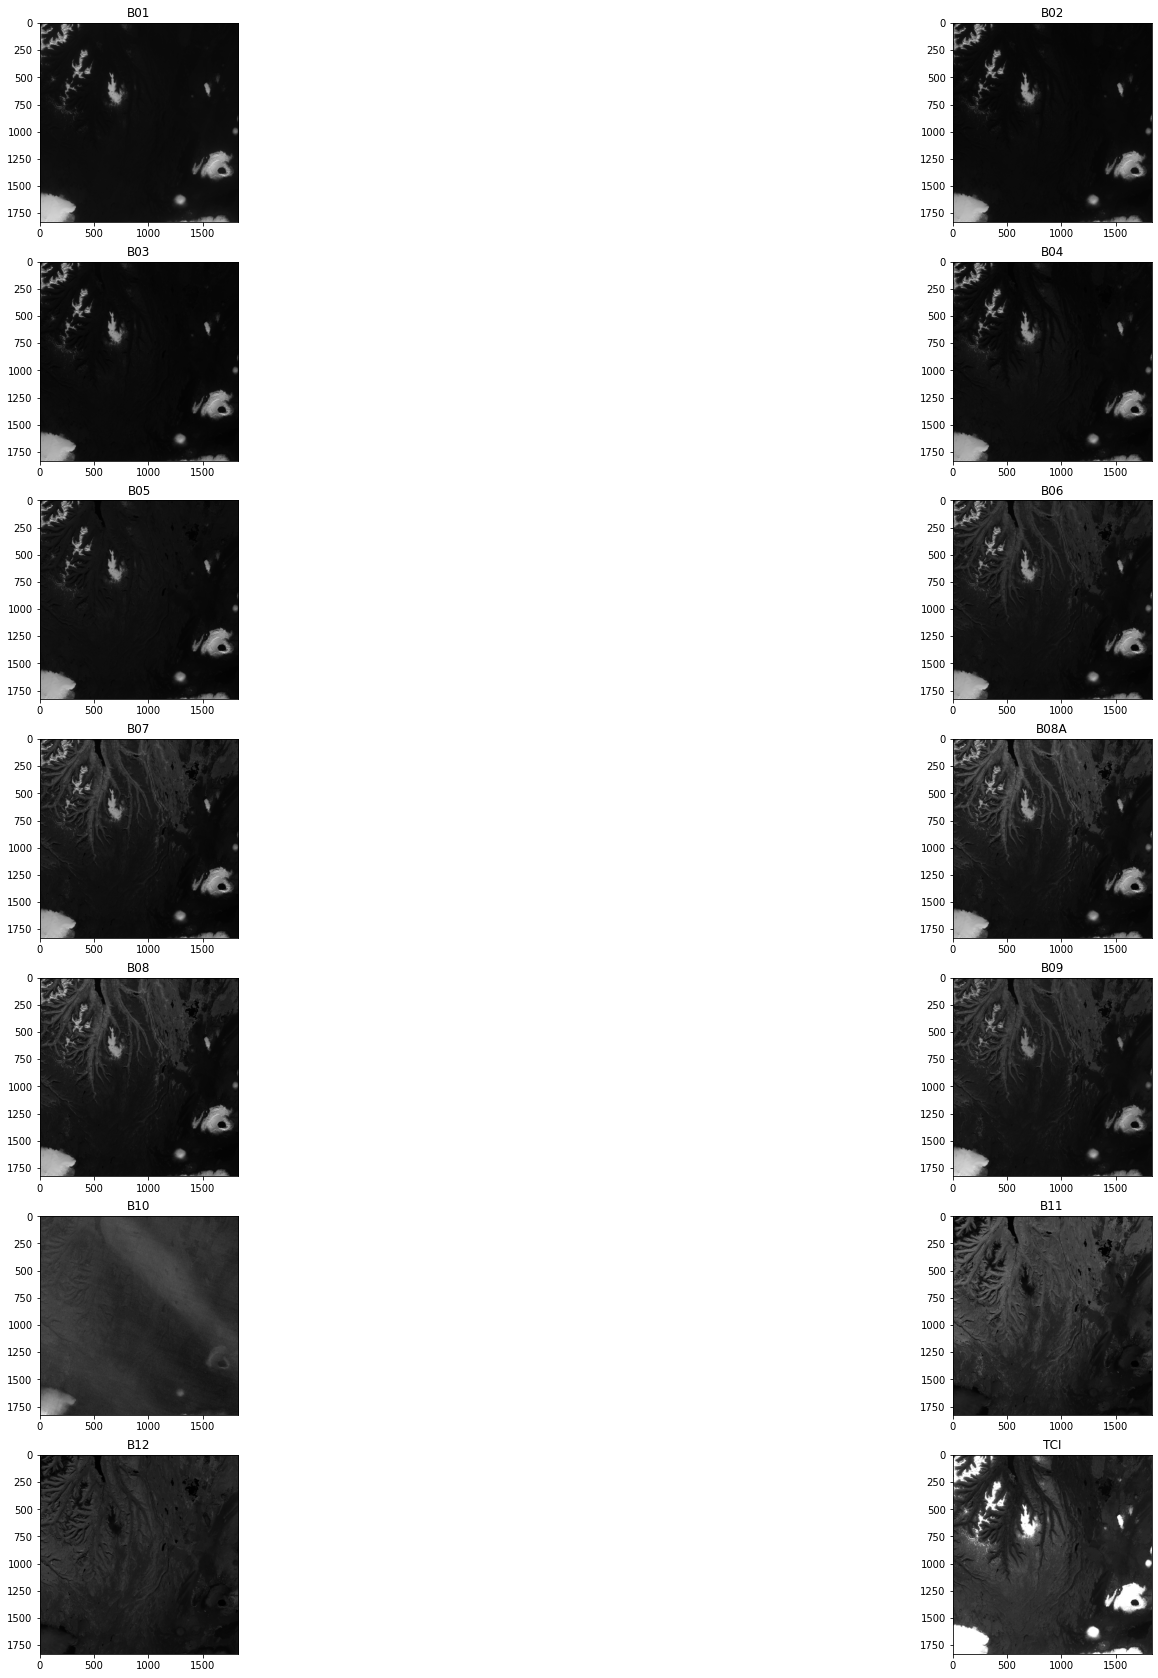

In [26]:
# Greyscale plots can be seen below
data=list(dataR60m.values())
fig = plt.figure(figsize=(30,30))
for i in range(len(bands)):
    A=plt.subplot2grid((7,2),(i//2,i%2))
    A.imshow(data[i].read()[0],cmap='gray')
    A.set_title(bands[i])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


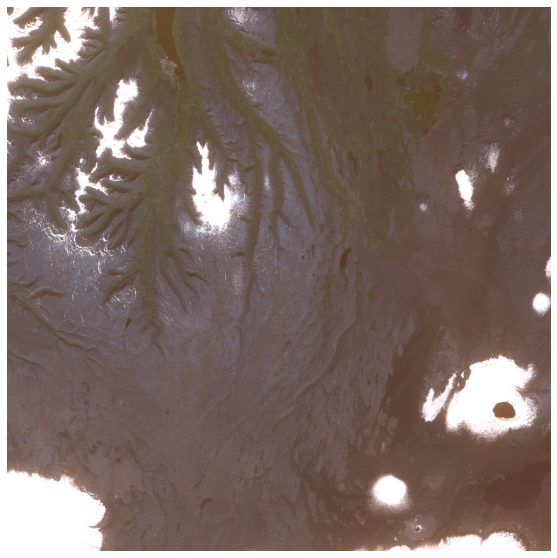

In [27]:
#To make a true-color plot, red, blue, green are combined
band=['B02','B03','B04']
#taking data for the specific bands
dataRGB=[]
for i in band:
    dataRGB.append(dataR60m[i])
#Now to stack the images upon each other
stack_list=[]
for i in dataRGB:
    stack_list.append(i.read()[0].flatten()/3000)
stack=np.array(stack_list).T
rgb_arr = np.array(np.split(stack, dataRGB[0].width))
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(rgb_arr)

# Function Definitions

In [28]:
#I will need data to create stacks, so a function was made for that
def createData(raster_dict,bands):
    data=[]
    for i in bands:
        data.append(raster_dict[i])
    return data
#Since I will need to stack the bands together, it is useful to define a stacking function
def data2stack(data):
    array_1D=[]
    for i in data:
        array_1D.append(i.read()[0].flatten())
    stack=np.array(array_1D).T
    return stack



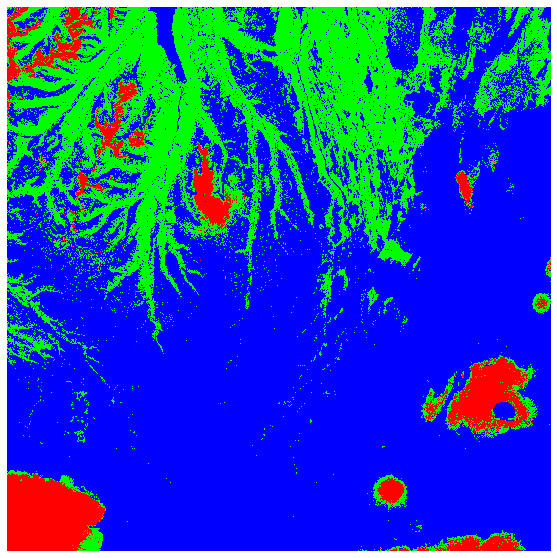

In [30]:
#Now I can try the K-means algorithm
#From inspection it can be seen that three classes is asthetically pleasing but not informative enough
n_classes=3
data=createData(dataR60m,bands)
stack = data2stack(data)
kmeans = KMeans(n_clusters=n_classes).fit(stack)

label_array = np.array(np.split(kmeans.labels_, data[0].width))

plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(label_array, cmap='brg', interpolation='nearest')


#Checking the number of occurences

In [31]:
for i in range(n_classes):
  print('Label', i, ' : ',np.count_nonzero(kmeans.labels_ == i),  'occurences')

Label 0  :  2345146 occurences
Label 1  :  188147 occurences
Label 2  :  815607 occurences


#Creating scatter plot for the clusters

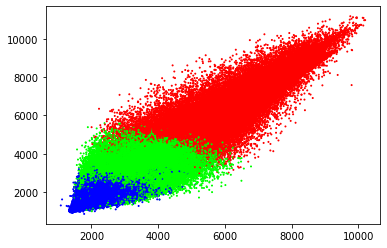

In [32]:
plt.scatter(stack.T[0], stack.T[1], c=kmeans.labels_, cmap='brg', s=1, alpha=1)

In [33]:
# Determination of optimal number of clusters using elbow method

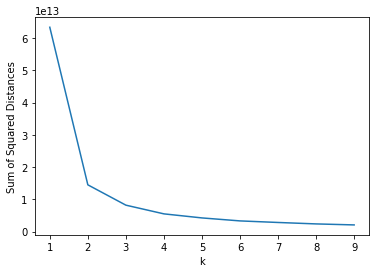

In [40]:
#Before determining the optimal number of bands to use, one must determine optimal number of classes
sum_of_SDs=[]
#To set expectations for how many classes there are, the maximum number of classes is set to 10
K=range(1,10)

data=createData(dataR60m,bands)
stack = data2stack(data)

#Now, using the intertia attribute to calculate sum of squared distances
for k in K:
    model=KMeans(n_clusters=k)
    model=model.fit(stack)
    sum_of_SDs.append(model.inertia_)
#Now to check the plot
plt.plot(K,sum_of_SDs)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.show()

#The elbow occurs at 4, so I will use 4 clusters from now on.

In [ ]:
#Using all the bands with 3 classes
n_classes=4
data=createData(dataR60m,bands)
stack = data2stack(data)
kmeans = KMeans(n_clusters=n_classes).fit(stack)

label_arr = np.array(np.split(kmeans.labels_, data[0].width))

plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(label_arr, cmap='brg', interpolation='nearest')

In [ ]:
#Checking number of occurances
for i in range(n_classes):
  print('Label', i, ' : ',np.count_nonzero(kmeans.labels_ == i),  'occurences')

In [ ]:
#Creating scatter plot for occurences
plt.scatter(stack.T[0], stack.T[1], c=kmeans.labels_, cmap='brg', s=1, alpha=1)

# Determination of optimum bands to use

In [ ]:
#The optimal number of bands to use was seemingly determined using the pearson correlation coefficient
from scipy import stats
data=dataR60m
array= []
for i in data.values():
  row = []
  for j in data.values():
    pearson_coeff = stats.pearsonr(i.read()[0].flatten(), j.read()[0].flatten())[0]
    pearson_coeff = round(ndigits=2, number=pearson_coeff)
    row.append(pearson_coeff)
    
  array.append(row)

df=pd.DataFrame(array, columns=data.keys(), index=data.keys())

In [ ]:
#Now getting which bands to use
corr=df.corr()
cols=np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1,corr.shape[0]):
        if corr.iloc[i,j]>=0.5:
            if cols[j]:
                cols[j]=False
selected_cols=df.columns[cols]
data=df[selected_cols]
print(data)

#It can be seen from the above dataframe that the bands that have the least correlation among them are B01, B10 and B11

# Running K-means for optimal number of clusters and optimum bands

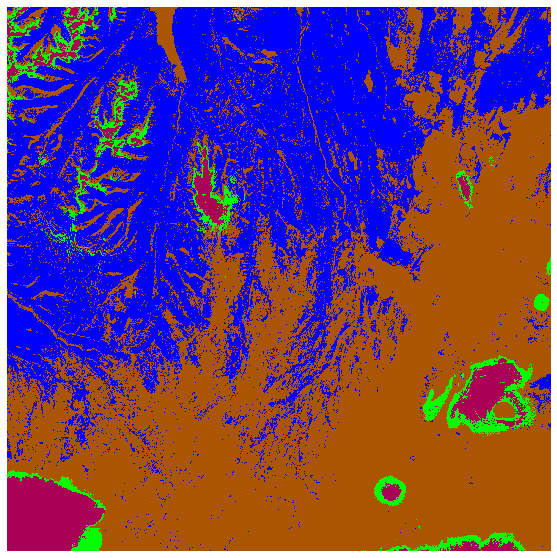

In [39]:
# From the above dataframe, it is apparent that the bands which have the least correlation among them are B01, B10 and B11
band=['B01','B10','B11']
n_classes=4
data=createData(dataR60m,band)
stack = data2stack(data)
kmeans = KMeans(n_clusters=n_classes).fit(stack)

label_arr = np.array(np.split(kmeans.labels_, data[0].width))

plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(label_arr, cmap='brg', interpolation='nearest')


In [38]:
#Checking number of occurances
for i in range(n_classes):
  print('Label', i, ' : ',np.count_nonzero(kmeans.labels_ == i),  'occurences')

Label 0  :  1108013 occurences
Label 1  :  137332 occurences
Label 2  :  994954 occurences
Label 3  :  103684 occurences
Label 4  :  1004917 occurences


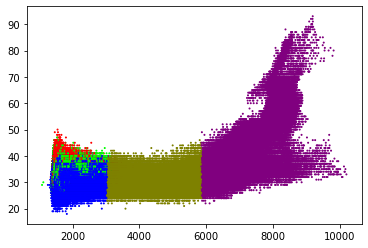

In [37]:
#Creating scatter plot for occurences
plt.scatter(stack.T[0], stack.T[1], c=kmeans.labels_, cmap='brg', s=1, alpha=1)

In [36]:
#In the above classified K-Means output, glaciers are seen in pink, rocks/sand in green, tundra vegetaion in orange.
#Blue is both water and flood plain it seems. 
#Four classes appears not to be enough to distinguish from floodplain, despite four bands being suggested by the elbow rule

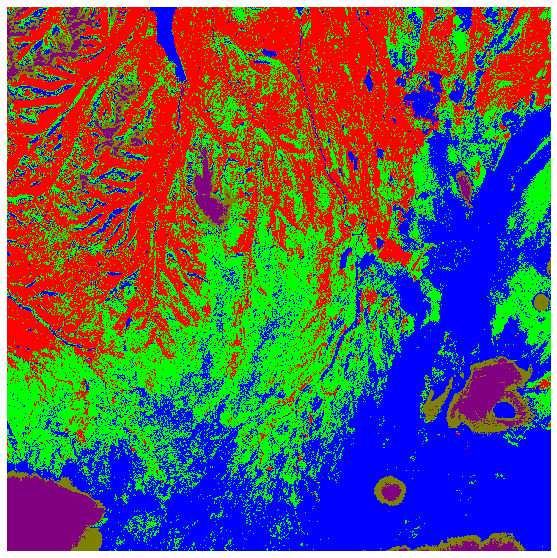

In [35]:
# From the above dataframe, it is apparent that the bands which have the least correlation among them are B01, B10 and B11
band=['B01','B10','B11']
n_classes=5
data=createData(dataR60m,band)
stack = data2stack(data)
kmeans = KMeans(n_clusters=n_classes).fit(stack)

label_arr = np.array(np.split(kmeans.labels_, data[0].width))

plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(label_arr, cmap='brg', interpolation='nearest')


In [ ]:
#Checking number of occurances
for i in range(n_classes):
  print('Label', i, ' : ',np.count_nonzero(kmeans.labels_ == i),  'occurences')

In [ ]:
#Creating scatter plot for occurences
plt.scatter(stack.T[0], stack.T[1], c=kmeans.labels_, cmap='brg', s=1, alpha=1)

In [ ]:
# With five bands clustering still does not seperate floodplains (likely from lahars) from waters at the base of fjords jutting inland 
#These results appear to lend credence to the efficacy of the elbow rule, or at a minimum raising questions how much better five classes are than four

# Alternative Clustering Alorithms

#I tried using other algorithms with full uncropped images. However, I ran into problems as they required too much disk space. 660GB is too much for a C drive to handle much less an partially full external hardrive. Instead, I focused on the Askja volcano and nearby rift valley before re-applying the algorithms

In [ ]:
#First location of subset is defined
dataset=rasterio.open(ImgList[-1])
print(dataset.xy(dataset.height//2,dataset.width//2))
subset=(698000.0,7220000.0,70,70)
def crop_image(dataset, x, y, row, col):
  row_off,col_off = dataset.index(x,y)
  window = rasterio.windows.Window(col_off, row_off, row, col)
  return dataset.read(window=window).astype('float')[0]
     
plt.imshow(
  crop_image(dataset, *subset), cmap='gray')

#Now that the image is cropped, Birch clustering is run

In [ ]:
#Birch
band=['B01','B10','B11']
n_classes=4
data=createData(dataR60m,band)
stack = np.array([crop_image(i, *subset).flatten() for i in data]).T
birch = Birch(n_clusters=n_classes,
                  threshold=0.5).fit(stack)
label_array = np.array(np.split(birch.labels_, subset[3]))

plt.axis('off')
plt.imshow(label_array, cmap='brg', interpolation='nearest')

In [ ]:
#Checking number of occurances
for i in range(n_classes):
  print('Label', i, ' : ',np.count_nonzero(birch.labels_ == i),  'occurences')

In [ ]:
#Creating scatter plot for occurences
plt.scatter(stack.T[0], stack.T[1], c=birch.labels_, cmap='brg', s=1, alpha=1)

In [ ]:
#Ward
band=['B01','B10','B11']
n_classes=4
data=createData(dataR60m,band)
stack = np.array([crop_image(i, *subset).flatten() for i in data]).T
ward = AgglomerativeClustering(n_clusters=n_classes).fit(stack)
label_array = np.array(np.split(ward.labels_, subset[3]))

plt.axis('off')
plt.imshow(label_array, cmap='brg', interpolation='nearest')

In [20]:
#Heirachical clustering provided by Birch and Ward does appear to yield better results than K-Means 
#A major drawback to K-Means is that it relies upon mimimum distance to mean, which is notoriously faulty
#We need to used ground truth for that. However, during the implementation, I realized that k-means might not be the best but at least it works with full images. 
#However, as seen, heirachical clustering techniues tend to take too much space, even on cropped images.
#With that said K-Means appears to produce fuzzier boundaries than Birch and Ward, yet another reason K-Means is sub-optimal 
#Further analysis techniques such as mean-shift can be used

In [ ]:
#Checking number of occurances
for i in range(n_classes):
  print('Label', i, ' : ',np.count_nonzero(ward.labels_ == i),  'occurences')

In [ ]:
#Creating scatter plot for occurences
plt.scatter(stack.T[0], stack.T[1], c=ward.labels_, cmap='brg', s=1, alpha=1)